# MACA 

In [1]:
%matplotlib inline

# https://github.com/pangeo-data/scikit-downscale/blob/main/examples/bcsd_example.ipynb
# 

In [93]:
import xarray as xr
#import xesmf as xe
#import intake
#
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
import numpy as np
import cmocean
import pandas as pd

#import xsd
import warnings
warnings.filterwarnings('ignore')


from skdownscale.pointwise_models import PointWiseDownscaler
import skdownscale.pointwise_models.bcsd as bcsd
bcsd_model = PointWiseDownscaler(bcsd.BcsdTemperature(return_anoms=False), dim='time')

In [94]:
# load datasets : 
dir="/home/bijan/Documents/scripts/isimip3basd/data/"
var="tas_"
# obs 
obs_fine = xr.open_dataset(dir+var+"obs-hist_fine_1979-2014.nc")
obs_coarse = xr.open_dataset(dir+var+"obs-hist_coarse_1979-2014.nc")
# hist:
sim_hist = xr.open_dataset(dir+var+"sim-hist_coarse_1979-2014.nc")
# future:
sim_fut = xr.open_dataset(dir+var+"sim-fut_coarse_2065-2100.nc")




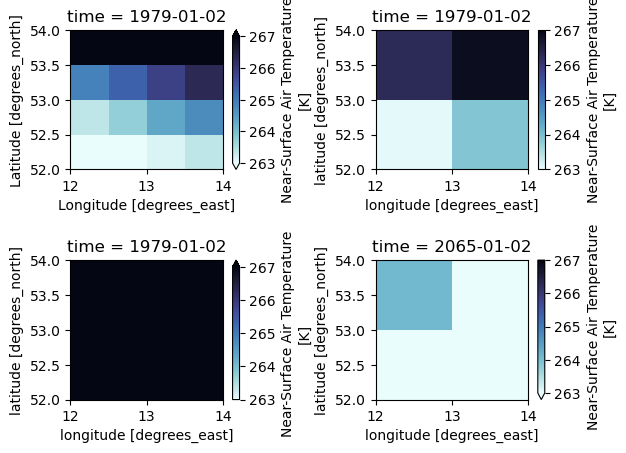

In [95]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)

obs_fine.tas.isel(time=1).plot.pcolormesh(ax=ax1,x="lon", y="lat", cmap=cmocean.cm.ice_r, vmin=263, vmax=267)
obs_coarse.tas.isel(time=1).plot.pcolormesh(ax=ax2,x="lon", y="lat",cmap=cmocean.cm.ice_r, vmin=263, vmax=267)
sim_hist.tas.isel(time=1).plot.pcolormesh(ax=ax3,x="lon", y="lat",cmap=cmocean.cm.ice_r, vmin=263, vmax=267)
sim_fut.tas.isel(time=1).plot.pcolormesh(ax=ax4,x="lon", y="lat",cmap=cmocean.cm.ice_r, vmin=263, vmax=267)
# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.65, wspace=0.6)
plt.show()

## Epoch Adjustment

In [96]:
# calculate the 21-day rolling average over historical periods
mean_pcp_train = obs_coarse.tas.rolling(time=21, center=True).mean()

# calculate the historical mean slice
annual_mean_pcp_train = mean_pcp_train.groupby('time.dayofyear').mean()

In [97]:
# calculate the 21-day rolling average over control period
mean_pcp_hist = sim_hist.sel(time=slice("1979","2014")).rolling(time=21, center=True).mean()

# calculate the historical mean slice
annual_mean_pcp_hist = mean_pcp_hist.groupby('time.dayofyear').mean()

In [98]:
# calculate the 21-day rolling average over future period
mean_pcp_f = sim_fut.sel(time=slice("2065","2100")).rolling(time=21, center=True).mean()

# calculate the historical mean slice
annual_mean_pcp_f = mean_pcp_f.groupby('time.dayofyear').mean()

In [99]:
# epoch adjustment
# for future period
pcp_f_epoch_adjust = sim_fut.sel(time=slice("2069","2100")).groupby('time.dayofyear')/ (annual_mean_pcp_f/annual_mean_pcp_hist)

In [100]:
pcp_f_epoch_adjust.load()

<xarray.Dataset>
Dimensions:    (lat: 2, lon: 2, time: 11687)
Coordinates:
  * lat        (lat) float64 53.5 52.5
  * lon        (lon) float64 12.5 13.5
  * time       (time) datetime64[ns] 2069-01-01 2069-01-02 ... 2100-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    tas        (lon, lat, time) float32 262.4 261.9 265.3 ... 276.0 275.8 272.7

In [101]:
sim_hist.load()

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 2, time: 13149)
Coordinates:
  * lat      (lat) float64 53.5 52.5
  * lon      (lon) float64 12.5 13.5
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2014-12-31
Data variables:
    tas      (lon, lat, time) float32 279.7 277.8 278.7 ... 279.6 276.5 272.2

## step3: Coarse bias correction

In [104]:


# train the model
bcsd_model.fit(sim_hist.to_array(), obs_coarse.to_array())
# predict with the model  (downscaled_temp: xr.DataArray)
sim_fut_ba = bcsd_model.predict(sim_fut.to_array()).load()

## disaggregate the downscaled data (final: xr.DataArray)
#final = bcsd_disaggregator(sim_fut_ba, obs_fine.to_array())
display(bcsd_model, bcsd_model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    BcsdTemperature(return_anoms=False)

<xarray.DataArray (lon: 2, lat: 2)>
array([[BcsdTemperature(return_anoms=False),
        BcsdTemperature(return_anoms=False)],
       [BcsdTemperature(return_anoms=False),
        BcsdTemperature(return_anoms=False)]], dtype=object)
Coordinates:
  * lat      (lat) float64 53.5 52.5
  * lon      (lon) float64 12.5 13.5

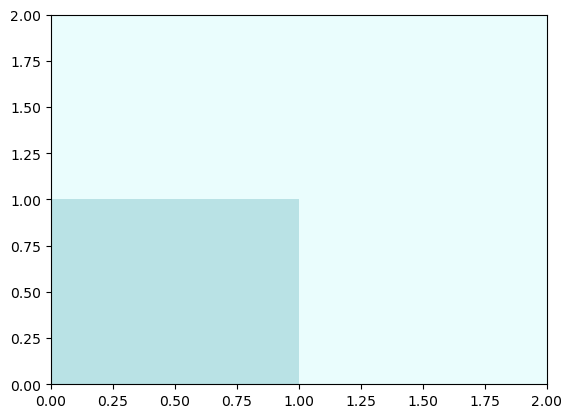

In [109]:
plt.pcolormesh(sim_fut_ba.variable.squeeze()[2,:,:],cmap=cmocean.cm.ice_r, vmin=263, vmax=267)#.plot.pcolormesh(cmap=cmocean.cm.ice_r, vmin=263, vmax=267)

In [74]:
sim_fut_ba.variable.squeeze().shape

(13148, 2, 2)